In [1]:
import pandas as pd
import re
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 322
!pip freeze > requirements.txt

#импортировали исходные данные
df = pd.read_csv('main_task.csv')
df_kaggle = pd.read_csv('kaggle_task.csv')
sample_sumbission = pd.read_csv('sample_submission.csv')
df['sample'] = 1 # помечаем где у нас трейн
df_kaggle['sample'] = 0 # помечаем где у нас тест
df_kaggle['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_kaggle.append(df, sort=False).reset_index(drop=True) # объединяем

data
df = data
df

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


In [2]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [3]:
#функции обработки

#считаем % пропусков по каждому признаку
#функция missing_data(data) будет принимать на вход датасет, и определять % пропусков и тип данных
def missing_data(data):
    for i in data.columns:
        md = 100-data[i].isna().value_counts()[0]*100/len(data[i])
        print('% пропусков в',i, md)
    return

#функция конвертации строковых данных в столбце Price Range, на фход идет серия, на выходе числовые значения 
#ghbpyfrf ценовой категории
def price_cat(data):
    if data == '$':
        return 1
    elif data == '$$ - $$$':
        return 2
    elif data == '$$$$':
        return 3

#функция которая получает на вход серию со списком всех кухонь и убирает аартефакты в названиях,
#формируя список 
def resplit(ct):
    ct = ct.replace(", ",'')
    ct = ct.replace("[",'')
    ct = ct.replace("]",'')
    ct = re.split("'(.*?)'",ct)
    ct = list(filter(None, ct))
    return ct

#функция разбивки типов кухонь , нужная для выполенния заданий в модуле
def split_cuisine(ct):
    if re.findall(r"'(.*?)'", ct) == 'Unknown':
        return 'Unknown'
    else:
        return  re.findall(r"'(.*?)'", ct)

#простая функция длинны списка
def len_list(data):
    return len(data)


# функиця разделения даты из отзывов
# тип данных строка, визуально похожая на списки
# необходимо разпарсить данные
# кроме того , в строке есть дата отзыва, ее тоже надо достать
# кол-во дат будет равно кол-ву отзывов

def split_date(ct):
    if re.findall(r'\d\d/\d\d/\d{4}', ct) == 'None':
        return dt.datetime(1900,12,31)
    else:
        return  re.findall(r'\d\d/\d\d/\d{4}', ct)
    
# функция возвращает разницу между первым и последним отзывом в формате datetime
def deltadays(rd):
    if len(rd)>=2:
        a = dt.datetime.strptime(rd[0], '%m/%d/%Y') - dt.datetime.strptime(rd[len(rd)-1], '%m/%d/%Y')
        return a
    else:
        return dt.timedelta(0)

def learn_fit(df, random_state = None):
    #X - данные о ресторанах, Y - целевая переменная
    X = df.drop(['Rating', 'Restaurant_id'], axis = 1)
    y = df['Rating']
    
    # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
    # выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)
    
    #создаем модель
    regr = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=-1, random_state=RANDOM_SEED)
    #обучение на тесте
    regr.fit(X_train, y_train)
    
    #используем полученную (обученную модель) для предсказания рейтинга в тестовой сборке
    #полученное значение пишем в отдульную переменную
    y_predict = regr.predict(X_test)
    
    #сравниваем предсказанное значение y_predict с тестовым y_test
    print('MAE Regression:', metrics.mean_absolute_error(y_test,y_predict))
    print('MAE Regression round state:', metrics.mean_absolute_error(y_test,np.round(y_predict*2)/2))
    
    #классификация
    le = LabelEncoder()
    le.fit(y_train)
    classif = RandomForestClassifier(n_estimators = 100, random_state=RANDOM_SEED, n_jobs=-1)
    classif.fit(X_train, le.transform(y_train))
    y_predict = classif.predict(X_test)
    print('MAE Классификация:', metrics.mean_absolute_error(y_test,le.inverse_transform(y_predict)))
    
#    plt.rcParams['figure.figsize'] = (10,10)
#    feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
#    feat_importances.nlargest(15).plot(kind='barh')

In [4]:
missing_data(df)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.180000000000007
% пропусков в Ranking 0.0
% пропусков в Price Range 34.721999999999994
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0


In [5]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [6]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.34551783170533173
MAE Regression round state: 0.33384615384615385
MAE Классификация: 0.3828632478632479


In [7]:
#удаляем признак как не влияющий на качество 

#df.drop(columns=['ID_TA'], inplace=True)
#df_kaggle.drop(columns=['ID_TA'], inplace=True)


In [8]:
# City

df.groupby('City').Rating.agg(['mean','std','count']).sort_values(by=['mean'], ascending=False)

,mean,std,count
City,,,
Athens,3.423325,1.734354,776
Rome,3.395326,1.730001,2589
Ljubljana,3.389640,1.664843,222
Oporto,3.338785,1.757784,642
Krakow,3.315884,1.756785,554
Vienna,3.295218,1.703231,1443
Berlin,3.285952,1.757230,2705
Edinburgh,3.270470,1.743363,745
Amsterdam,3.270044,1.753022,1372


In [9]:
#импортируем данные по городам мира, и заберем оттуда только столицы (признак primary)
cities = pd.read_csv('worldcities.csv')
cities = cities[cities['capital']=='primary']

#уберем ненужную информацию и сформируем список столиц мира, хотя нам надо только европу, но все же
cities.drop(['city_ascii', 'lat','lng','capital','id','admin_name'], inplace=True, axis=1)
cities_list=list(cities['city'])

#вводим новый признак Столица, 1 если город столичный, 0 если не столичный
df['capital']=df['City'].apply(lambda x: 1 if x in cities_list else 0 )
df_kaggle['capital']=df['City'].apply(lambda x: 1 if x in cities_list else 0 )
display(df)

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,1
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,0
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,1
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,1
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,1


Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.323343432030932
MAE Regression round state: 0.31017094017094016
MAE Классификация: 0.35341880341880344


In [10]:
#получаем список уникальных городов
city_list=df['City'].unique()

#попробуем добавить численность населения
city_list={'Paris':2.148, 'Stockholm':0.975, 'London':8.961, 'Berlin':3.669, 'Munich':1.488, 'Oporto':0.287,
       'Milan':1.1399, 'Bratislava':0.428, 'Vienna':1.921, 'Rome':2.790, 'Barcelona':1.664, 'Madrid':3.334,
       'Dublin':1.173, 'Brussels':1.212, 'Zurich':0.434, 'Warsaw':1.793, 'Budapest':1.750, 'Copenhagen':0.794,
       'Amsterdam':0.860, 'Lyon':0.518, 'Hamburg':1.845, 'Lisbon':0.506, 'Prague':1.335, 'Oslo':0.693,
       'Helsinki':0.655, 'Edinburgh':0.488, 'Geneva':0.201, 'Ljubljana':0.286, 'Athens':0.664,
       'Luxembourg':0.644, 'Krakow':0.779}
df['population'] = df.City.replace(to_replace=city_list)


In [12]:
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,population
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,2.148
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,0.655
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0.488


In [13]:
#проверяем модель

In [14]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.18134871794871793
MAE Regression round state: 0.16042735042735043
MAE Классификация: 0.18012820512820513


In [16]:
#Отлично!!! модель улучшена почти в 2 раза, играем дальше


In [17]:
#узнаем модальное значение для категории Price Range
#rjnjhsv позже заполним пропуски
print('Модальное значение для категории Price Range',df['Price Range'].mode()[0])



range_replace={'$':1, '$$ - $$$':2, '$$$$':3}

df['Price Range']=df['Price Range'].replace(to_replace=range_replace)

#заменим пропуски модальным значением
df['Price Range'].fillna(2, inplace=True, axis=0)

#делаем тоже самое с кэгл
#df_kaggle['Price Range']=df_kaggle['Price Range'].replace(to_replace=range_replace)
#df_kaggle['Price Range'].fillna(2, inplace=True, axis=0)

#проверяем пропуски
missing_data(df)

#проверяем модель , уже не удаляем столбец Price Range т.к. мы его изменили 
drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Модальное значение для категории Price Range $$ - $$$
% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.180000000000007
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.18066965811965813
MAE Regression round state: 0.16004273504273503
MAE Классификация: 0.1838034188034188


In [19]:
#есть  небольшое улучшение 


In [20]:
#Добавим признак цены в городе

price_in_city_dict = df.groupby('City')['Price Range'].mean().to_dict()
df['Price in City'] = df['City'].map(price_in_city_dict)


In [21]:
#опять проверяем модель

drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.17832008547008546
MAE Regression round state: 0.1579059829059829
MAE Классификация: 0.17884615384615385


In [23]:
#Попробуем поиграть с кухнями

#добавили количество кухонь в ресторане? это данные внешнего парсинга сайта tripadvisor
#т.к. scraping занимает много времени, его провели отдельным проектом, а здесь только импортируем результаты
#xnj бы сократить время
cuisine = pd.read_csv('cuisine.csv')
#missing_data(cuisine)
#видим что удалось убрать пропуски в признаке Cuisine Style
#теперь заменим данные на данные парсинга и сразу посчитаем кол-во кухонь в ресторане создав новый признак

#display(cuisine.info())

df['Cuisine Style'] = cuisine['Cuisine Style'].apply(resplit)


df['col_cuisine'] = df['Cuisine Style'].apply(len)


#проверим результат добавления нового признака
#drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
#print('Смотрим на предикт\n')
#learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

#видим что есть улучшение, оставляем признак col_cuisine

#посчиатем сколько уникальных кухонь есть в принципе

unique_cuisine = df['Cuisine Style'].explode().unique()
unique_cuisine

#добавим признак соотношения кол-ва кухонь в ресторане к макс кол-ву кухонь в городе

dict = pd.DataFrame(df.groupby('City')['Cuisine Style'].agg('sum'))
#display(dict)
dict['city_col_cuisine']=0
from  more_itertools import unique_everseen
#

for i in range(0,len(dict)):
    dict['city_col_cuisine'][i]=len(list(unique_everseen(dict['Cuisine Style'][i])))

dict_a = pd.DataFrame()

for i in range(0,len(dict)):
    new_row = {'city':dict.index[i], 'city_col_cuisine':dict.values[i][1]} 
    dict_a = dict_a.append(new_row, ignore_index=True)

new_dict = dict_a.set_index('city').T.to_dict('list')
new_dict

df['city_col_cuisine'] = df['City'].replace(to_replace=new_dict)

#dict['city_col_cuisine']=dict['Cuisine Style'].apply(len)
#dict

#drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
#print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
#learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)                   

#drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
#print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
#learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)
#mean_cuisine=df.groupby('City').col_cuisine.agg('mean').to_dict()
#mean_cuisine['Stockholm']
#df['Cuisine Style'] = df['Cuisine Style'].map(mean_cuisine)
#df['Cuisine Style'] = df['City'].replace(to_replace=mean_cuisine)
#df_kaggle['Cuisine Style'] = df['City'].replace(to_replace=mean_cuisine)


#df.sample(15)
#missing_data(df)

#drop_columns = ['City','Number of Reviews', 'URL_TA', 'ID_TA', 'Reviews']
#print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
#learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

#модель ухудшилась, убираем этот признак !!! 

<ipython-input-23-a71a49c91ffd>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict['city_col_cuisine'][i]=len(list(unique_everseen(dict['Cuisine Style'][i])))


In [24]:
df['cuisine_norm']=df['col_cuisine']/df['city_col_cuisine']
df
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.1770136752136752
MAE Regression round state: 0.15376068376068375
MAE Классификация: 0.17756410256410257


In [30]:
#есть небольшое улучшение - изменим и тестовую

#df

#df3=df[['URL_TA','col_cuisine']]

#df4 = pd.merge(df_kaggle, df3, how = 'left')
#display(df4)
#missing_data(df4)
#display(df[df['Restaurant_id']=='id_0'])
#display(df_kaggle[df_kaggle['Restaurant_id']=='id_0'])
#df_kaggle['col_cuisine'] = cuisine['col_cuisine'].apply(resplit)
#df_kaggle['col_cuisine'] = df['col_cuisine'].apply(len)
df['City'].value_counts().to_dict()

{'London': 7193,
 'Paris': 6108,
 'Madrid': 3813,
 'Barcelona': 3395,
 'Berlin': 2705,
 'Milan': 2694,
 'Rome': 2589,
 'Prague': 1816,
 'Lisbon': 1647,
 'Vienna': 1443,
 'Amsterdam': 1372,
 'Brussels': 1314,
 'Hamburg': 1186,
 'Munich': 1145,
 'Lyon': 1126,
 'Stockholm': 1033,
 'Budapest': 1021,
 'Warsaw': 925,
 'Dublin': 836,
 'Copenhagen': 819,
 'Athens': 776,
 'Edinburgh': 745,
 'Zurich': 685,
 'Oporto': 642,
 'Geneva': 590,
 'Krakow': 554,
 'Oslo': 488,
 'Helsinki': 475,
 'Bratislava': 380,
 'Luxembourg': 263,
 'Ljubljana': 222}

In [26]:
#создадим признак, кол-во ресторанов в городе
per_city_dict = df['City'].value_counts().to_dict()
per_city_dict
df['city_restaurants'] = df.City.map(per_city_dict)

# Добавим признак - нормализованный ранг ranking_norm
df['ranking_norm'] = df.Ranking / df.city_restaurants

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)


Смотрим на предикт с новыми признаками

MAE Regression: 0.17685940170940173
MAE Regression round state: 0.15367521367521367
MAE Классификация: 0.16350427350427352


In [43]:
#отношение кол-ва кухонь в ресторане к среднему кол-ву кухонь в этом городе

mean_city_cuisine = df.groupby('City')['col_cuisine'].mean().to_dict()
mean_city_cuisine

df['mcc'] = df.City.replace(to_replace=mean_city_cuisine)
df['mcc_norm_by_city']=df['col_cuisine']/df['mcc']

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
print('Смотрим на предикт с новым признаком\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с новым признаком

MAE Regression: 0.1762619658119658
MAE Regression round state: 0.15371794871794872
MAE Классификация: 0.16705128205128206


In [ ]:
#Улучшили, но не сильно - оставим


In [48]:
#missing_data(df)
#остались пропуски в Number of reviews

nor = pd.read_excel('df_pars.xls')
missing_data(nor)

% пропусков в Unnamed: 0 0.0
% пропусков в id 0.0
% пропусков в city 0.0
% пропусков в url_ta 0.0
% пропусков в id_ta 0.0
% пропусков в nor 0.0


In [49]:
#отличный результат , повысили еще точность
#сделаем тоже и на kaggle

per_city_dict = df_kaggle['City'].value_counts().to_dict()
per_city_dict
df_kaggle['city_restaurants'] = df_kaggle.City.map(per_city_dict)
# Добавим признак - нормализованный ранг ranking_norm
df_kaggle['ranking_norm'] = df_kaggle.Ranking / df_kaggle.city_restaurants
df_kaggle.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,city_restaurants,ranking_norm
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0,1,1211,10.704377
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0,1,99,1.070707
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0,0,149,5.436242


In [153]:
#display(df.head(3))
#display(df_kaggle.head(3))







  # ПОПРОБУЕМ еще немного добавить признаков
    
missing_data(df_kaggle)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.069999999999993
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 6.569999999999993
% пропусков в Reviews 0.01999999999999602
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в city_restaurants 0.0
% пропусков в ranking_norm 0.0


In [50]:
#делаем dummy
display(df.sample(5))
#display(df_kaggle.sample(5))
#df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)
#df_kaggle = pd.get_dummies(df_kaggle, columns=[ 'City',], dummy_na=True)


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,capital,population,Price in City,col_cuisine,city_col_cuisine,cuisine_norm,city_restaurants,ranking_norm,mcc,mcc_norm_by_city
6801,id_6801,Berlin,"[American, Fast Food, Vegetarian Friendly]",233.0,1.0,233.0,"[['Tasty!', 'Great burgers, low price'], ['12/...",/Restaurant_Review-g187323-d6956839-Reviews-To...,d6956839,0,...,1,3.669,1.862477,3,108.0,0.027778,2705,0.086137,2.268762,1.322307
11061,id_895,Warsaw,"[French, Polish, European, Contemporary]",896.0,2.0,30.0,"[['Cosy and tasty', 'Strong YES!'], ['12/22/20...",/Restaurant_Review-g274856-d10260499-Reviews-M...,d10260499,1,...,1,1.793,1.886486,4,81.0,0.049383,925,0.968649,2.485405,1.609395
5629,id_5629,London,"[Turkish, Mediterranean, Vegetarian Friendly, ...",5499.0,1.0,59.0,"[['Great Find', 'Very good'], ['09/17/2017', '...",/Restaurant_Review-g186338-d1381502-Reviews-Cl...,d1381502,0,...,1,8.961,1.861949,4,120.0,0.033333,7193,0.764493,2.942583,1.359350
8811,id_8811,Barcelona,"[Chinese, Mediterranean, Asian, Thai, Fusion, ...",584.0,2.0,178.0,"[['Nice place with friendly host', 'Amazing fo...",/Restaurant_Review-g187497-d7721173-Reviews-Ma...,d7721173,0,...,0,1.664,1.856259,8,108.0,0.074074,3395,0.172018,2.659499,3.008085
13854,id_4777,Rome,[Italian],4778.0,2.0,6.0,"[[], []]",/Restaurant_Review-g187791-d9797930-Reviews-Le...,d9797930,1,...,1,2.790,1.788722,1,94.0,0.010638,2589,1.845500,3.261105,0.306645


In [26]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df['sample'] = 1 # помечаем где у нас трейн
df_kaggle['sample'] = 0 # помечаем где у нас тест
df_kaggle['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df.append(df_kaggle, sort=False).reset_index(drop=True) # объединяем

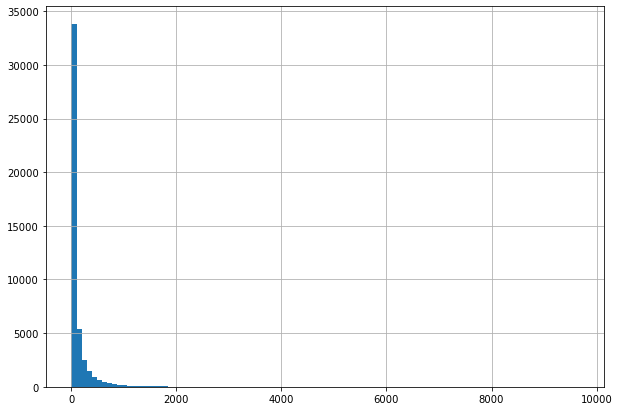

In [57]:
# посмотрим распределение признака


plt.rcParams['figure.figsize'] = (10,7)
data['Number of Reviews'].hist(bins=100)



<AxesSubplot:>

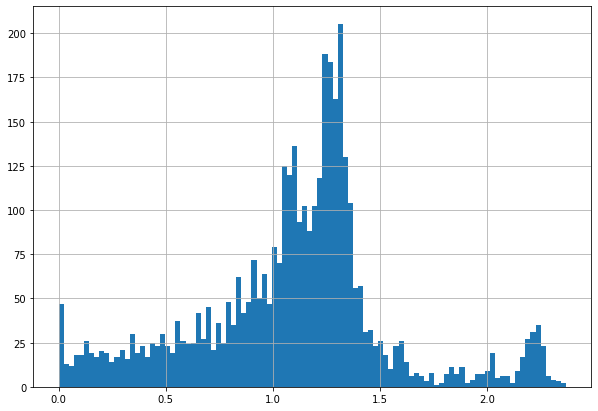

In [58]:
# посмотрим распределение относительно цели
df['ranking_norm'][df['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

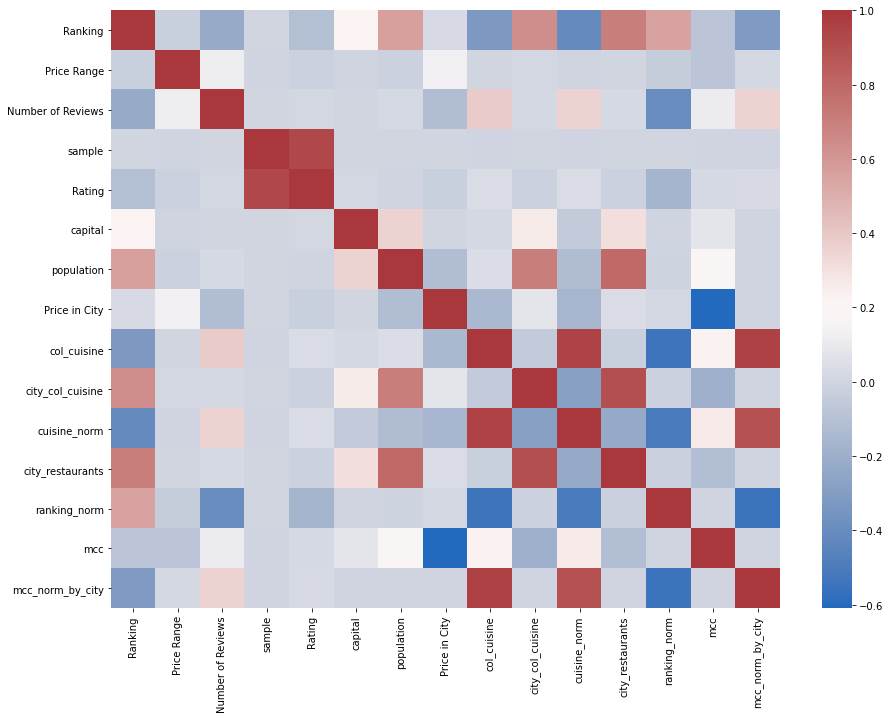

In [60]:
import seaborn as sns 
plt.rcParams['figure.figsize'] = (15,11)
sns.heatmap(df.corr(), cmap='vlag')

In [73]:
dfc=df['Cuisine Style'].explode().unique()
len(dfc)
dfc

array(['Bar', 'Pub', 'European', 'Scandinavian', 'Gluten Free Options',
       'Vegetarian Friendly', 'Vegan Options', 'Italian', 'Mediterranean',
       'Seafood', 'French', 'Cafe', 'Fast Food', 'Portuguese', nan,
       'Greek', 'Friendly', 'Czech', 'Eastern European',
       'Central European', 'Pizza', 'British', 'Spanish', 'Norwegian',
       'African', 'Moroccan', 'Middle Eastern', 'Halal', 'Indian', 'Thai',
       'Dutch', 'Welsh', 'American', 'Steakhouse', 'Soups', 'Scottish',
       'Fusion', 'Street Food', 'Hungarian', 'Asian', 'Wine Bar',
       'Barbecue', 'Central American', 'Deli', 'Peruvian',
       'South American', 'Irish', 'Polish', 'Vietnamese', 'Lebanese',
       'Turkish', 'Healthy', 'Japanese', 'Sushi', 'Austrian', 'Chinese',
       'Danish', 'International', 'Gastropub', 'Korean', 'German',
       'Contemporary', 'Food', 'Arabic', 'Diner', 'Swiss', 'Swedish',
       'Persian', 'Dessert', 'Eastern', 'Options', 'Australian', 'Grill',
       'Mexican', 'Bites', 'Lat

In [77]:
#============================================================================
#создадим отдельный дата фрейм с разбивкой по городам и айди ресторанов
#и диапазонам цены, что бы определить среднее для каждого города
#CPR city price range
#============================================================================

cpr = df[['City','Price Range']]
display(cpr.value_counts())
display(cpr[cpr['City']=='London'].value_counts())
rpr = df[['Restaurant_id','Price Range']]
display(rpr.value_counts())

from sklearn.preprocessing import LabelEncoder
#City encoding
le = LabelEncoder()
le.fit(df.City)
df['city_le']=le.transform(df.City)

df[15:25]
missing_data(df)


City        Price Range
London      2.0            5648
Paris       2.0            5096
Madrid      2.0            3251
Barcelona   2.0            2699
Berlin      2.0            2221
                           ... 
Luxembourg  1.0              15
Bratislava  3.0              14
Krakow      3.0              13
Luxembourg  3.0              11
Ljubljana   3.0               7
Length: 93, dtype: int64

City    Price Range
London  2.0            5648
        1.0            1269
        3.0             276
dtype: int64

Restaurant_id  Price Range
id_561         2.0            17
id_227         2.0            16
id_344         2.0            16
id_453         2.0            16
id_200         2.0            15
                              ..
id_2571        1.0             1
id_2570        1.0             1
id_257         3.0             1
id_7559        2.0             1
id_9999        2.0             1
Length: 19064, dtype: int64

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 0.0
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
% пропусков в Price in City 0.0
% пропусков в col_cuisine 0.0
% пропусков в city_col_cuisine 0.0
% пропусков в cuisine_norm 0.0
% пропусков в city_restaurants 0.0
% пропусков в ranking_norm 0.0
% пропусков в mcc 0.0
% пропусков в mcc_norm_by_city 0.0
% пропусков в city_le 0.0


In [78]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
print('Смотрим на предикт с новым признаком\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с новым признаком

MAE Regression: 0.17568376068376068
MAE Regression round state: 0.15307692307692308
MAE Классификация: 0.1679059829059829


In [83]:
#улучшили еще чуть-чуть
df

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Price in City,col_cuisine,city_col_cuisine,cuisine_norm,city_restaurants,ranking_norm,mcc,mcc_norm_by_city,city_le,pop_le
0,id_0,Paris,"[Bar, Pub]",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,1.926981,2,114.0,0.017544,6108,2.122299,2.131794,0.938177,24,26
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,1.911579,5,80.0,0.062500,475,0.223158,2.591579,1.929326,12,9
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,1.766443,1,73.0,0.013699,745,1.087248,3.710067,0.269537,9,5
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,1.861949,5,120.0,0.041667,7193,0.232031,2.942583,1.699187,16,30
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,1.936842,6,63.0,0.095238,380,0.097368,2.039474,2.941935,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,2.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,1.845583,4,100.0,0.040000,2694,0.185598,2.489978,1.606440,20,16
49996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,2.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,1.926981,5,114.0,0.043860,6108,1.038147,2.131794,2.345442,24,26
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,2.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,1.969022,2,85.0,0.023529,1033,1.599226,2.448209,0.816924,27,15
49998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,2.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,1.886486,5,81.0,0.061728,925,0.692973,2.485405,2.011744,29,23


In [158]:


data['Number of Reviews'] = data['Number of Reviews'].fillna(0)
data
drop_columns = ['Restaurant_id','City', 'Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
data.drop(columns = drop_columns, inplace=True)
df_preproc = data

df_preproc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            50000 non-null  float64
 1   Price Range        50000 non-null  int64  
 2   Number of Reviews  50000 non-null  float64
 3   sample             50000 non-null  int64  
 4   Rating             50000 non-null  float64
 5   capital            50000 non-null  int64  
 6   population         50000 non-null  float64
 7   Price in City      50000 non-null  float64
 8   city_restaurants   50000 non-null  int64  
 9   ranking_norm       50000 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 3.8 MB


In [163]:
df_preproc.sample(10)
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            50000 non-null  float64
 1   Price Range        50000 non-null  int64  
 2   Number of Reviews  50000 non-null  float64
 3   sample             50000 non-null  int64  
 4   Rating             50000 non-null  float64
 5   capital            50000 non-null  int64  
 6   population         50000 non-null  float64
 7   Price in City      50000 non-null  float64
 8   city_restaurants   50000 non-null  int64  
 9   ranking_norm       50000 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 3.8 MB


In [164]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)


In [170]:

display(train_data.sample(5))
display(test_data.sample(5))
display(y)
display(X)

,Ranking,Price Range,Number of Reviews,Rating,capital,population,Price in City,city_restaurants,ranking_norm
37165,260.0,3,124.0,4.5,1,3.3340,1.916077,3813,0.068188
43420,3203.0,1,8.0,4.5,0,1.6640,1.856259,3395,0.943446
48741,7884.0,2,8.0,5.0,1,8.9610,1.861949,7193,1.096066
28436,67.0,2,137.0,4.5,1,0.4280,1.936842,380,0.176316
28015,5330.0,2,51.0,3.0,0,1.1399,1.845583,2694,1.978471


,Ranking,Price Range,Number of Reviews,Rating,capital,population,Price in City,city_restaurants,ranking_norm
1330,2314.0,2,96.0,0.0,1,1.335,1.840308,1816,1.274229
9481,171.0,2,406.0,0.0,0,0.779,1.763538,554,0.308664
1268,10814.0,2,3.0,0.0,1,8.961,1.861949,7193,1.503406
8803,623.0,1,90.0,0.0,1,1.173,1.839713,836,0.745215
6770,658.0,2,52.0,0.0,1,1.335,1.840308,1816,0.362335


array([3.5, 4. , 4.5, ..., 4.5, 4. , 3. ])

,Ranking,Price Range,Number of Reviews,capital,population,Price in City,city_restaurants,ranking_norm
10000,5570.0,2,194.0,1,2.1480,1.926981,6108,0.911919
10001,1537.0,2,10.0,1,0.9750,1.969022,1033,1.487899
10002,353.0,3,688.0,1,8.9610,1.861949,7193,0.049075
10003,3458.0,2,3.0,1,3.6690,1.862477,2705,1.278373
10004,621.0,2,84.0,0,1.4880,1.944105,1145,0.542358
...,...,...,...,...,...,...,...,...
49995,500.0,2,79.0,0,1.1399,1.845583,2694,0.185598
49996,6341.0,2,542.0,1,2.1480,1.926981,6108,1.038147
49997,1652.0,2,4.0,1,0.9750,1.969022,1033,1.599226
49998,641.0,2,70.0,1,1.7930,1.886486,925,0.692973


In [188]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [189]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape, y_train.shape

((10000, 8), (40000, 9), (40000, 8), (30000, 8), (10000, 8), (30000,))

In [190]:
#ML

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)


y_pred = (y_pred * 2).round()/2


# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


MAE: 0.191


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [191]:
#test_data = test_data.drop(['Rating'], axis=1)


In [192]:
sample_submission

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.0


In [193]:
#drop_columns = ['City', 'Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
#print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
#learn_fit(test_data.drop(columns = drop_columns).dropna(), random_state=322)
#test_data

In [194]:
predict_submission = model.predict(test_data)
predict_submission = (predict_submission * 2).round()/2

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [195]:
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4. , 4.5])

In [196]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


In [197]:
df_kaggle

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,id_9995,"['Caribbean', 'Barbecue', 'Jamaican', 'Vegetar...",4367.0,1.0,28.0,[['By far best Chicken burgers and wings in L....,/Restaurant_Review-g186338-d11916827-Reviews-C...,d11916827,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,id_9996,"['Indian', 'Asian', 'Nepali', 'Bangladeshi']",2612.0,2.0,2.0,"[['Ok indian food'], ['11/25/2017']]",/Restaurant_Review-g189158-d12701633-Reviews-C...,d12701633,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,id_9997,NaN,5562.0,2.0,2.0,"[[], []]",/Restaurant_Review-g187849-d13198194-Reviews-Q...,d13198194,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,id_9998,['Italian'],4010.0,2.0,2.0,"[[], []]",/Restaurant_Review-g187849-d3862815-Reviews-La...,d3862815,0,0,...,0,0,0,0,0,0,0,0,0,0


In [198]:
df

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,0,0,0,0,0,0,0,0,0,0
49996,id_6340,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,0,0,1,0,0,0,0,0,0,0
49997,id_1649,"['Japanese', 'Sushi']",1652.0,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,0,0,0,0,0,1,0,0,0,0
49998,id_640,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,0,0,0,0,0,0,0,1,0,0
